In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

# Check gradient

In [2]:
D3 = nn.ConvTranspose2d(1024, 128, 7, stride=1, padding=0)
D2 = nn.ConvTranspose2d(128, 32, 5, stride=1, padding=0)
D1 = nn.ConvTranspose2d(32, 3, 6, stride=2, padding=0)

x = torch.randn(1, 1024, 2, 2, requires_grad=True)
y = torch.randn(1, 3, 28, 28, requires_grad=True)

f = torch.div(torch.square(torch.norm(y - D1(D2(D3(x))),2)), 2)

gradient = grad(outputs=f, inputs=x)#, grad_outputs=torch.ones(y.size()), create_graph=True, retain_graph=True, only_inputs=True)[0]
print(gradient[0].shape)

with torch.no_grad():
    approx = F.conv2d(
                F.conv2d(
                            F.conv2d(D1(D2(D3(x)))-y, D1.weight, stride=2, padding=0), 
                            D2.weight, stride=1, padding=0
                        ), 
                        D3.weight, stride=1, padding=0
                    )
#with torch.no_grad():
    #approx = F.conv2d(y, D3.weight, stride=1, padding=0)
    
print(approx.shape)
torch.sum(torch.abs(approx - gradient[0]))

torch.Size([1, 1024, 2, 2])
torch.Size([1, 1024, 2, 2])


tensor(0.0003)

In [3]:
x = torch.randn(5, 3, 28, 28)
y = torch.randn(5, 3, 28, 28)

f = torch.div(torch.square(y - x).flatten(1).sum(1), 2) + torch.abs(x).flatten(1).sum(1)
print(f.shape)
print(f)
print(torch.abs(x).flatten(1).sum(1).shape)

torch.Size([5])
tensor([4212.6240, 4126.0771, 4228.3755, 4212.0278, 4020.9753])
torch.Size([5])


In [4]:
def soft_threshold(x, lambd):
    return torch.sign(x) * torch.max(torch.abs(x) - lambd, torch.zeros_like(x))

def hard_threshold(x, lambd):
    return x * (torch.abs(x) > lambd).float()

class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.layer1 = nn.ConvTranspose2d(32, 1, 6, stride=2, padding=0)
        self.layer2 = nn.ConvTranspose2d(128, 32, 5, stride=1, padding=0)
        self.layer3 = nn.ConvTranspose2d(1024, 128, 7, stride=1, padding=0)
    
    def FISTA(self, x, y, lambd = 0.1):
        # F.conv2d(x, self.layer1.weight)
        # x is gamma_L the sparse coding
        # y is the ground truth image
        batch_size = x.size(0)
        Dx = self.forward(x)# self.layer1(self.layer2(self.layer3(x)))
        gradient = F.conv2d(
                                F.conv2d(
                                            F.conv2d(
                                                        Dx - y, self.layer1.weight, 
                                                        stride=2, padding=0
                                                    ), 
                                            self.layer2.weight, stride=1, padding=0
                                        ), 
                                self.layer3.weight, stride=1, padding=0
                            )
        # keep_going = True
        tk, tk_next = torch.tensor(1., device = x.device), torch.tensor(1., device = x.device)
        loss_list = []
        for _ in range(10):
            z = x.clone()
            const = self.F(z, lambd).reshape(-1, 1, 1, 1)
            
            L = torch.ones((batch_size, 1, 1, 1), device = x.device)
            stop_line_search = torch.zeros((batch_size), device=x.device).bool()
            while torch.sum(stop_line_search) < batch_size:
                # line search
                # print(z.shape, gradient.shape, L.shape)
                prox_z = soft_threshold(z - torch.div(gradient, L), torch.div(lambd, L))
                
                # check descent condition
                temp1 = self.F(prox_z, lambd).reshape(-1, 1, 1, 1)
                temp2 = const + torch.mul(gradient, prox_z - z).flatten(1).sum(1).reshape(-1, 1, 1, 1) + \
                                torch.div(L, 2) * torch.square(prox_z - z).flatten(1).sum(1).reshape(-1, 1, 1, 1)
                stop_line_search = temp1 <= temp2
                L = torch.where(stop_line_search, L, 2 * L)
            
            tk_next = (1 + torch.sqrt(1 + 4 * tk**2)) / 2
            x = prox_z + torch.div(tk - 1, tk_next) * (prox_z - z)
            tk = tk_next
            
            loss_list.append(torch.mean(self.F(x, lambd)).item())
        
        return x, loss_list
    
    def normalize_weights(self):
        with torch.no_grad():
            self.layer1.weight = nn.Parameter(self.layer1.weight / torch.norm(self.layer1.weight, dim=(2, 3), keepdim=True))
            self.layer2.weight = nn.Parameter(self.layer2.weight / torch.norm(self.layer2.weight, dim=(2, 3), keepdim=True))
            self.layer3.weight = nn.Parameter(self.layer3.weight / torch.norm(self.layer3.weight, dim=(2, 3), keepdim=True))
    
    def IHT(self):
        lambd1, lambd2, lambd3 = 0.01, 0.005, 0.01#0.01, 0.005, 0.01
        # self.layer1.weight = hard_threshold(self.layer1.weight, lambd1)
        self.layer2.weight = nn.Parameter(hard_threshold(self.layer2.weight, lambd2))
        self.layer3.weight = nn.Parameter(hard_threshold(self.layer3.weight, lambd3))
        #self.layer2.weight = nn.Parameter(hard_threshold(self.layer2.weight, lambd2))
    def F(self, x, lambd = 0.1):
        return torch.div(torch.square(x).flatten(1).sum(1), 2) + lambd * torch.abs(x).flatten(1).sum(1)
    
    def forward(self, x):
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        
        return x
    

[1872.1397705078125, 1220.744873046875, 1048.43603515625, 1043.6629638671875, 1047.495849609375, 1048.4959716796875, 1049.04931640625, 1049.4521484375, 1049.661376953125, 1049.7706298828125]
0.185302734375


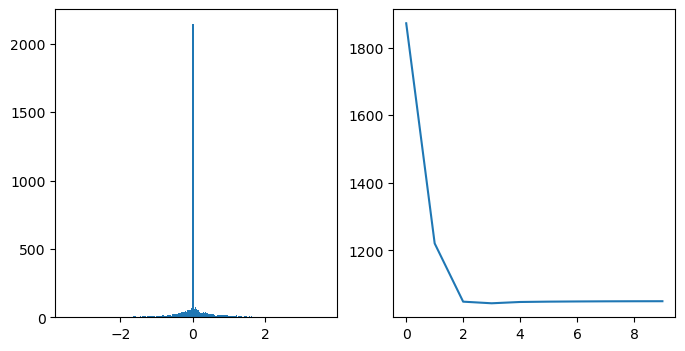

In [5]:
x = torch.randn(1, 1024, 2, 2)
y = torch.randn(1, 1, 28, 28)
model = net()

with torch.no_grad():
    x, loss = model.FISTA(x, y, .3)
print(loss)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(x.flatten().numpy(), bins=200)
ax[1].plot(loss)
print(np.sum(x.numpy().flatten()==0)/ x.numpy().size)

In [6]:
x = torch.randn(1, 1024, 2, 2)
model = net()
print(model(x).shape)

torch.Size([1, 1, 28, 28])


Text(0.5, 1.0, 'Hard Threshold')

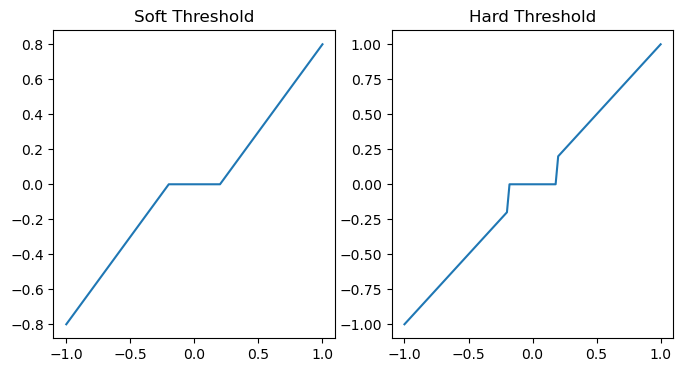

In [7]:
x = torch.linspace(-1,1,101)
#print(x)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x,soft_threshold(x, 0.2).numpy())
ax[1].plot(x,hard_threshold(x, 0.2).numpy())
ax[0].set_title('Soft Threshold')
ax[1].set_title('Hard Threshold')

In [9]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001)

for epoch in range(1, 21):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        x = torch.randn(data.size(0), 1024, 2, 2, device=device)
        with torch.no_grad():
            x, _ = model.FISTA(x, data, 0.3)
        optimizer.zero_grad()
        x = x.clone().requires_grad_(True)
        output = model(x)
        loss = F.mse_loss(output, data)# + 0.001 * (torch.norm(model.layer2.weight, 'fro') + torch.norm(model.layer3.weight, 'fro') + torch.norm(model.layer1.weight, 'fro'))
        loss.backward()
        optimizer.step()
        
        # iterative hard thresholding step
        model.IHT()
        #model.normalize_weights()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlayer2: {:.6f}\tlayer3: {:.6f}\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                np.sum(model.layer2.weight.cpu().detach().numpy().flatten()==0)/ model.layer2.weight.cpu().detach().numpy().size, 
                np.sum(model.layer3.weight.cpu().detach().numpy().flatten()==0)/ model.layer3.weight.cpu().detach().numpy().size,
                loss.item()))

Train Epoch: 1 [0/60000 (0%)]	layer2: 0.140186	layer3: 0.792190	Loss: 0.679620
Train Epoch: 1 [10000/60000 (17%)]	layer2: 0.140186	layer3: 0.792190	Loss: 0.107424
Train Epoch: 1 [20000/60000 (33%)]	layer2: 0.140186	layer3: 0.792190	Loss: 0.102715
Train Epoch: 1 [30000/60000 (50%)]	layer2: 0.140186	layer3: 0.792190	Loss: 0.099302
Train Epoch: 1 [40000/60000 (67%)]	layer2: 0.140186	layer3: 0.792190	Loss: 0.091637
Train Epoch: 1 [50000/60000 (83%)]	layer2: 0.140186	layer3: 0.792190	Loss: 0.093658
Train Epoch: 2 [0/60000 (0%)]	layer2: 0.140186	layer3: 0.792190	Loss: 0.090558
Train Epoch: 2 [10000/60000 (17%)]	layer2: 0.140186	layer3: 0.792190	Loss: 0.091664
Train Epoch: 2 [20000/60000 (33%)]	layer2: 0.140186	layer3: 0.792190	Loss: 0.093838
Train Epoch: 2 [30000/60000 (50%)]	layer2: 0.140186	layer3: 0.792190	Loss: 0.094030
Train Epoch: 2 [40000/60000 (67%)]	layer2: 0.140186	layer3: 0.792190	Loss: 0.091757
Train Epoch: 2 [50000/60000 (83%)]	layer2: 0.140186	layer3: 0.792190	Loss: 0.093325
Tr

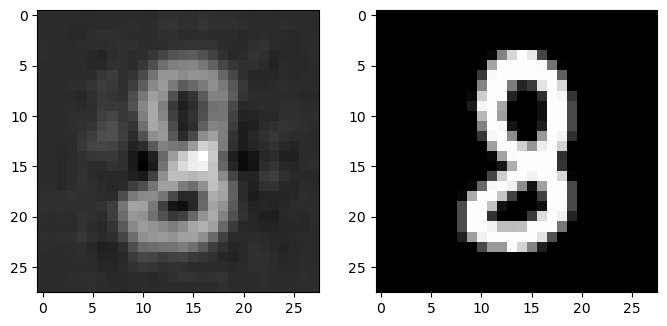

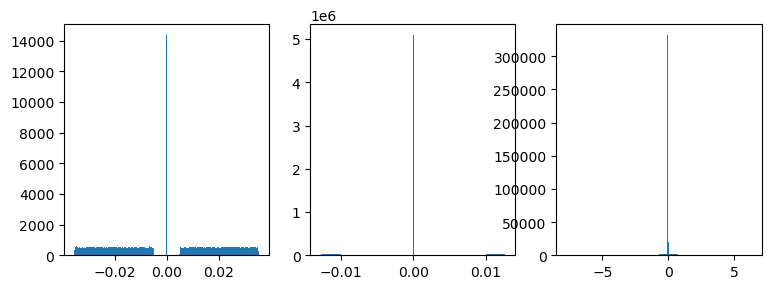

0.21543212890625


In [10]:
output.shape
idx = 56
#plt.imshow(output[idx].cpu().detach().numpy().reshape(28, 28), cmap='gray')
#plt.show()
#plt.imshow(data[idx].cpu().detach().numpy().reshape(28, 28), cmap='gray')

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(output[idx].cpu().detach().numpy().reshape(28, 28), cmap='gray')
ax[1].imshow(data[idx].cpu().detach().numpy().reshape(28, 28), cmap='gray')

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].hist(model.layer2.weight.cpu().detach().numpy().flatten(), bins=200)
ax[1].hist(model.layer3.weight.cpu().detach().numpy().flatten(), bins=200)
ax[2].hist(x.cpu().detach().numpy().flatten(), bins=200)
plt.show()

print(np.sum(x.cpu().detach().numpy().flatten()==0) / x.cpu().detach().numpy().size)

In [11]:
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
#visTensor(model.layer1.weight.cpu().detach(), ch=0, allkernels=True)

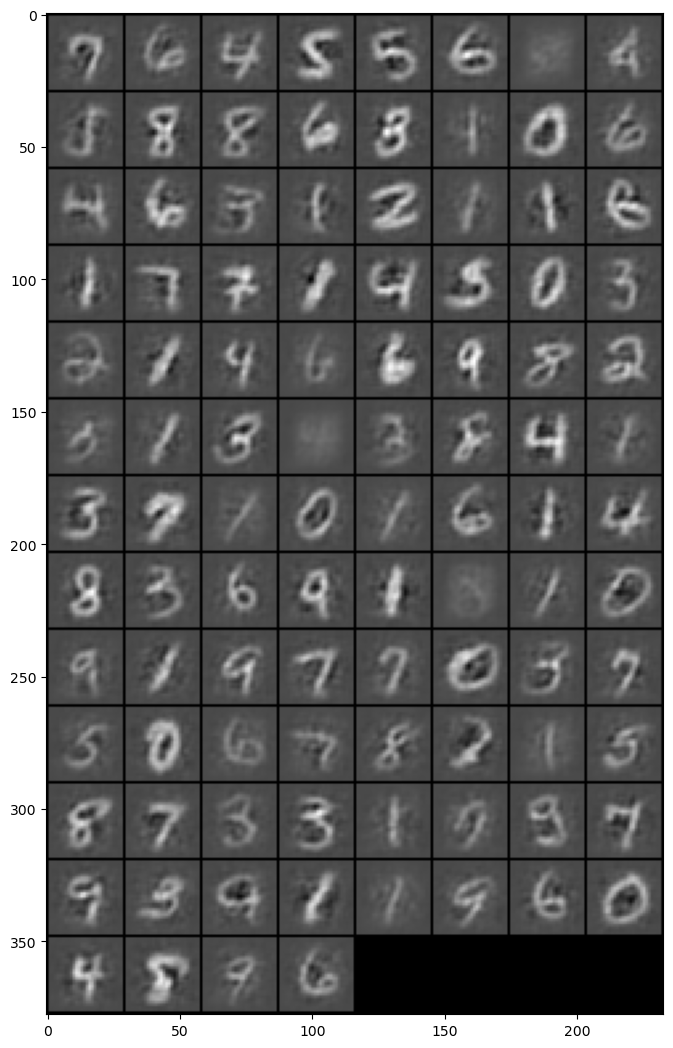

In [12]:
visTensor(output.cpu().detach(), ch=0, allkernels=True)